In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import nasdaqdatalink
import matplotlib.pyplot as plt
import requests
import json
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
# from torch.utils.data import DataLoader


In [2]:
#  https://docs.coinapi.io/market-data/rest-api/ohlcv
# Pull ETH data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_BTC_USD/history?period_id=1DAY&limit=10000'
headers = {'X-CoinAPI-Key' : '42D2F86D-F548-43D2-96C1-D7DB039EF63E'}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-09-11T00:00:00.0000000Z', 'time_period_end': '2023-09-12T00:00:00.0000000Z', 'time_open': '2023-09-11T00:01:04.0430000Z', 'time_close': '2023-09-11T02:29:48.5750000Z', 'price_open': 25839, 'price_high': 25870, 'price_low': 25661, 'price_close': 25716, 'volume_traded': 128.72365586, 'trades_count': 1236}, {'time_period_start': '2023-09-10T00:00:00.0000000Z', 'time_period_end': '2023-09-11T00:00:00.0000000Z', 'time_open': '2023-09-10T00:00:25.1010000Z', 'time_close': '2023-09-10T23:58:35.8900000Z', 'price_open': 25899, 'price_high': 26018, 'price_low': 25588, 'price_close': 25836, 'volume_traded': 879.78612157, 'trades_count': 7268}, {'time_period_start': '2023-09-09T00:00:00.0000000Z', 'time_period_end': '2023-09-10T00:00:00.0000000Z', 'time_open': '2023-09-09T00:00:01.0120000Z', 'time_close': '2023-09-09T23:59:53.1500000Z', 'price_open': 25908, 'price_high': 25927, 'price_low': 25801, 'price_close': 25899, 'volume_traded': 438.78189463, 'trades_count': 6596

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-09-11T00:00:00.0000000Z,2023-09-12T00:00:00.0000000Z,2023-09-11T00:01:04.0430000Z,2023-09-11T02:29:48.5750000Z,25839.0,25870.0,25661.0,25716.0,128.723656,1236
1,2023-09-10T00:00:00.0000000Z,2023-09-11T00:00:00.0000000Z,2023-09-10T00:00:25.1010000Z,2023-09-10T23:58:35.8900000Z,25899.0,26018.0,25588.0,25836.0,879.786122,7268
2,2023-09-09T00:00:00.0000000Z,2023-09-10T00:00:00.0000000Z,2023-09-09T00:00:01.0120000Z,2023-09-09T23:59:53.1500000Z,25908.0,25927.0,25801.0,25899.0,438.781895,6596
3,2023-09-08T00:00:00.0000000Z,2023-09-09T00:00:00.0000000Z,2023-09-08T00:00:00.8150000Z,2023-09-08T23:58:52.5340000Z,26256.0,26429.0,25652.0,25908.0,1646.440292,13583
4,2023-09-07T00:00:00.0000000Z,2023-09-08T00:00:00.0000000Z,2023-09-07T00:00:17.6080000Z,2023-09-07T23:59:17.2320000Z,25750.0,26417.0,25600.0,26245.0,1632.942744,11042


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

In [5]:
#inspect df
data.head()

,time_period_start,price_close
0,2023-09-11T00:00:00.0000000Z,25716.0
1,2023-09-10T00:00:00.0000000Z,25836.0
2,2023-09-09T00:00:00.0000000Z,25899.0
3,2023-09-08T00:00:00.0000000Z,25908.0
4,2023-09-07T00:00:00.0000000Z,26245.0


In [6]:
#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

In [7]:
#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

In [8]:
data.head()

,Date,Close
0,2023-09-11,25716.0
1,2023-09-10,25836.0
2,2023-09-09,25899.0
3,2023-09-08,25908.0
4,2023-09-07,26245.0


In [9]:
#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

In [10]:
data.head()

,Date,Close
4228,2011-09-13,5.97
4227,2011-09-14,5.53
4226,2011-09-15,5.13
4225,2011-09-16,4.85
4224,2011-09-17,4.87


In [11]:
# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# device

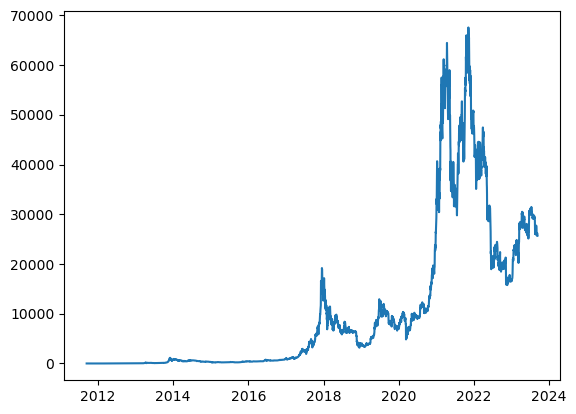

In [12]:
#plot historical eth price
plt.plot(data['Date'], data['Close'])

In [13]:
# build 1 week lookback for lstm training
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2011-09-20,5.66,4.90,4.92,4.87,4.85,5.13,5.53,5.97
2011-09-21,5.66,5.66,4.90,4.92,4.87,4.85,5.13,5.53
2011-09-22,5.72,5.66,5.66,4.90,4.92,4.87,4.85,5.13
2011-09-23,5.72,5.72,5.66,5.66,4.90,4.92,4.87,4.85
2011-09-24,5.68,5.72,5.72,5.66,5.66,4.90,4.92,4.87
...,...,...,...,...,...,...,...,...
2023-09-07,26245.00,25748.00,25783.00,25819.00,25970.00,25870.00,25798.00,25932.00
2023-09-08,25908.00,26245.00,25748.00,25783.00,25819.00,25970.00,25870.00,25798.00
2023-09-09,25899.00,25908.00,26245.00,25748.00,25783.00,25819.00,25970.00,25870.00


In [14]:
#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[5.6600e+00, 4.9000e+00, 4.9200e+00, ..., 5.1300e+00, 5.5300e+00,
        5.9700e+00],
       [5.6600e+00, 5.6600e+00, 4.9000e+00, ..., 4.8500e+00, 5.1300e+00,
        5.5300e+00],
       [5.7200e+00, 5.6600e+00, 5.6600e+00, ..., 4.8700e+00, 4.8500e+00,
        5.1300e+00],
       ...,
       [2.5899e+04, 2.5908e+04, 2.6245e+04, ..., 2.5819e+04, 2.5970e+04,
        2.5870e+04],
       [2.5836e+04, 2.5899e+04, 2.5908e+04, ..., 2.5783e+04, 2.5819e+04,
        2.5970e+04],
       [2.5716e+04, 2.5836e+04, 2.5899e+04, ..., 2.5748e+04, 2.5783e+04,
        2.5819e+04]])

In [15]:
shifted_df_as_np.shape

(4222, 8)

In [16]:
#scale data with min/max scaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.99989875, -0.99992125, -0.99992066, ..., -0.99991444,
        -0.9999026 , -0.99988957],
       [-0.99989875, -0.99989875, -0.99992125, ..., -0.99992273,
        -0.99991444, -0.9999026 ],
       [-0.99989698, -0.99989875, -0.99989875, ..., -0.99992214,
        -0.99992273, -0.99991444],
       ...,
       [-0.23333327, -0.23306683, -0.22309004, ..., -0.23570165,
        -0.23123134, -0.23419181],
       [-0.23519837, -0.23333327, -0.23306683, ..., -0.23676742,
        -0.23570165, -0.23123134],
       [-0.23875094, -0.23519837, -0.23333327, ..., -0.23780359,
        -0.23676742, -0.23570165]])

In [17]:
#check shapes
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((4222, 7), (4222,))

In [18]:
#Flip columns from T-1 first to T-7 first)

X = dc(np.flip(X, axis=1))
X

array([[-0.99988957, -0.9999026 , -0.99991444, ..., -0.99992214,
        -0.99992066, -0.99992125],
       [-0.9999026 , -0.99991444, -0.99992273, ..., -0.99992066,
        -0.99992125, -0.99989875],
       [-0.99991444, -0.99992273, -0.99992214, ..., -0.99992125,
        -0.99989875, -0.99989875],
       ...,
       [-0.23419181, -0.23123134, -0.23570165, ..., -0.23780359,
        -0.22309004, -0.23306683],
       [-0.23123134, -0.23570165, -0.23676742, ..., -0.22309004,
        -0.23306683, -0.23333327],
       [-0.23570165, -0.23676742, -0.23780359, ..., -0.23306683,
        -0.23333327, -0.23519837]])

In [19]:
#set train vs test (95% train, 5% test)

split_index = int(len(X) * 0.95)

split_index

4010

In [20]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4010, 7), (212, 7), (4010,), (212,))

In [21]:
#extra dimension for pytorch

X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4010, 7, 1), (212, 7, 1), (4010, 1), (212, 1))

In [22]:
#convert arrays to pytorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([4010, 7, 1]),
 torch.Size([212, 7, 1]),
 torch.Size([4010, 1]),
 torch.Size([212, 1]))

In [23]:
#turn raw tensors into torch dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [24]:
train_dataset

In [25]:

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [26]:
# for _, batch in enumerate(train_loader):
#     x_batch, y_batch = batch[0].to(device), batch[1].to(device)
#     print(x_batch.shape, y_batch.shape)
#     break

In [27]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        
#         h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
#         c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
# model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [31]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0], batch[1]
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [34]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0], batch[1]
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [35]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.021
Batch 200, Loss: 0.008

Val Loss: 0.024
***************************************************

Epoch: 2
Batch 100, Loss: 0.005
Batch 200, Loss: 0.003

Val Loss: 0.003
***************************************************

Epoch: 3
Batch 100, Loss: 0.002
Batch 200, Loss: 0.002

Val Loss: 0.001
***************************************************

Epoch: 4
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001

Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001

Val Loss: 0.001
***************************************************

Epoch: 6
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001

Val Loss: 0.001
***************************************************

Epoch: 7
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001

Val Loss: 0.001
***************************************************

Epoch: 8
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001

Val Loss: 0.001
***************************************************



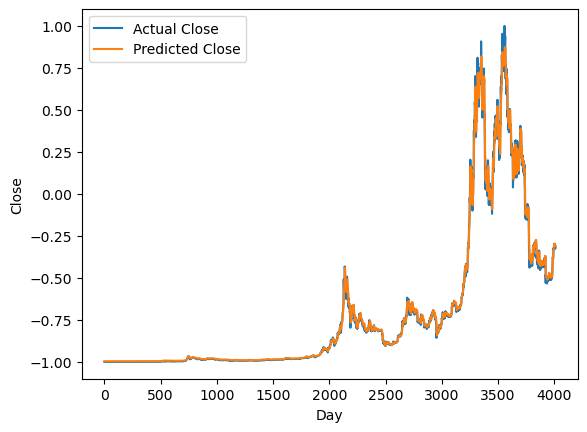

In [36]:
with torch.no_grad():
    predicted = model(X_train).numpy()
#     predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [37]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([  145.11726502,   145.22799918,   145.35886682, ...,
       23706.20240451, 23506.37959501, 23333.32626506])

In [38]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([5.66067883e+00, 5.66067883e+00, 5.71906593e+00, ...,
       2.29369997e+04, 2.27630000e+04, 2.32520001e+04])

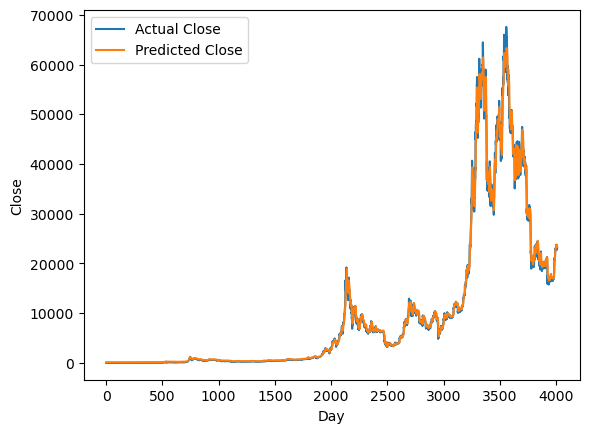

In [39]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [40]:
test_predictions = model(X_test).detach().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([23443.18763731, 22886.62164862, 22570.30449077, 22378.15958517,
       22443.04778886, 23395.31323378, 23549.41390913, 24137.2451842 ,
       24487.39565425, 24543.24392388, 24829.94372096, 24798.00597623,
       24661.23016336, 24486.14033156, 24052.06142257, 23807.64697402,
       23836.85663175, 23804.55547764, 23638.23176452, 23771.77011326,
       23762.03859405, 23289.92451487, 23041.03841966, 22918.19598398,
       22832.77766727, 22697.05886227, 22404.5284084 , 21676.7351967 ,
       21224.32072437, 21115.05832325, 21701.24167271, 22899.65807913,
       23811.50958281, 24177.87455372, 24722.713795  , 26099.48618757,
       26589.04039341, 27378.00919444, 27661.61246178, 28009.99722533,
       27797.59300205, 28176.96520992, 27934.77349794, 27848.19146588,
       28012.56374113, 27693.61463366, 27609.1607108 , 28045.76687529,
       28097.77719965, 28357.69342375, 28483.1970026 , 28426.51017338,
       28245.78648959, 28320.08911011, 28335.34827719, 28288.41964405,
      

In [41]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([21868.00026907, 21788.9995002 , 21790.00013432, 22211.00033249,
       24332.00039592, 23520.99952399, 24579.99961119, 24640.00041178,
       24295.99971424, 24843.00028496, 24449.99972217, 24187.99968253,
       23938.99983313, 23189.00039591, 23160.99975386, 23562.00035628,
       23492.99988861, 23136.00000751, 23633.9997063 , 23465.99988069,
       22358.99955569, 22346.99999958, 22428.00002336, 22406.99979349,
       22200.00040383, 21703.99995994, 20366.99975383, 20220.00015809,
       20617.99986481, 22182.99969044, 24208.9999124 , 24749.99969839,
       24368.00007093, 25049.99967461, 27466.000067  , 26979.99992432,
       28053.99996   , 27814.99990847, 28191.99988866, 27320.0000987 ,
       28343.00000756, 27493.00007493, 27498.99985298, 28003.99996396,
       27141.99997188, 27271.99986091, 28352.99980543, 28039.00001152,
       28475.99978562, 28468.99987677, 28186.0001106 , 27816.00003926,
       28178.00007097, 28183.00022157, 28051.00007097, 27930.99997981,
      

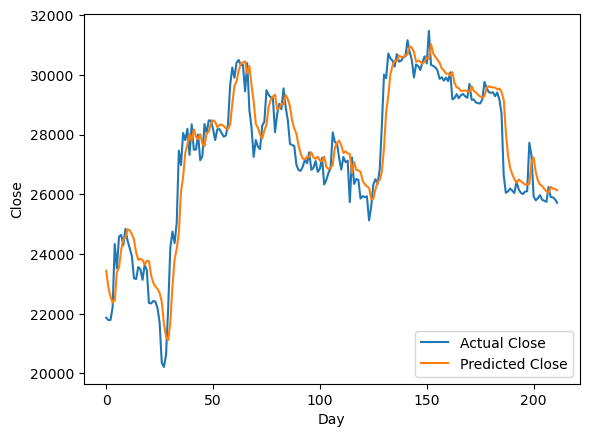

In [42]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
mydata = nasdaqdatalink.get("FRED/GDP", start_date="2001-12-31", end_date="2005-12-31")

In [ ]:
print(mydata)

In [ ]:
mydata = nasdaqdatalink.get(["WIKI/TSLA.11"])

In [ ]:
print(mydata)

In [ ]:
import requests

In [ ]:
# https://gist.github.com/bruhbruhroblox/dd9d981c8c37983f61e423a45085e063


def get_ticker(company_name):
    yfinance = "https://query2.finance.yahoo.com/v1/finance/search"
    user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'
    params = {"q": company_name, "quotes_count": 1, "country": "United States"}

    res = requests.get(url=yfinance, params=params, headers={'User-Agent': user_agent})
    data = res.json()

    company_code = data['quotes'][0]['symbol']
    return company_code

In [ ]:
stock = get_ticker("Apple")

print(stock)

In [ ]:
call = f'["WIKI/{stock}"]'

In [ ]:
print(call)

In [ ]:
mydata = nasdaqdatalink.get(call)

In [ ]:
print(mydata)